In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_followup_bd_20ms import XBOX2TrendFollowupBD20msSelect
from src.xbox2_specific.datasets.XBOX2_trend_primo_bd_20ms import XBOX2TrendPrimoBD20msSelect
from src.xbox2_specific.datasets.XBOX2_event_primo_bd_20ms import XBOX2EventPrimoBD20msSelect
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer
from src.utils.dataset_creator import load_dataset

not_swan_default_modules = ["shap","coloredlogs"]
for name in not_swan_default_modules:
    if not name in sys.modules:
        !pip install --user name

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


# Load Dataset
To load a dataset the dataset name and path to data has to be supplied.
This information is then passed to the `load_dataset` function which returns training, validation and test set.

For the xbox2 dataset some additional information is passed to the dataset loader.
First, the `manual_split` argument can be used to specify custom splitting of the data using run numbers.
Secondly, the `manual_scale` argument can be used to specify if scaling should
be done using mean and variance of each run.

In [2]:
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

# path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")
path_to_data = Path("C:\\Users\\holge\\cernbox\\CLIC_data\\Xbox2_hdf_new2\\")
train, valid, test = load_dataset(creator=XBOX2EventPrimoBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=None)

# Plot Dataset

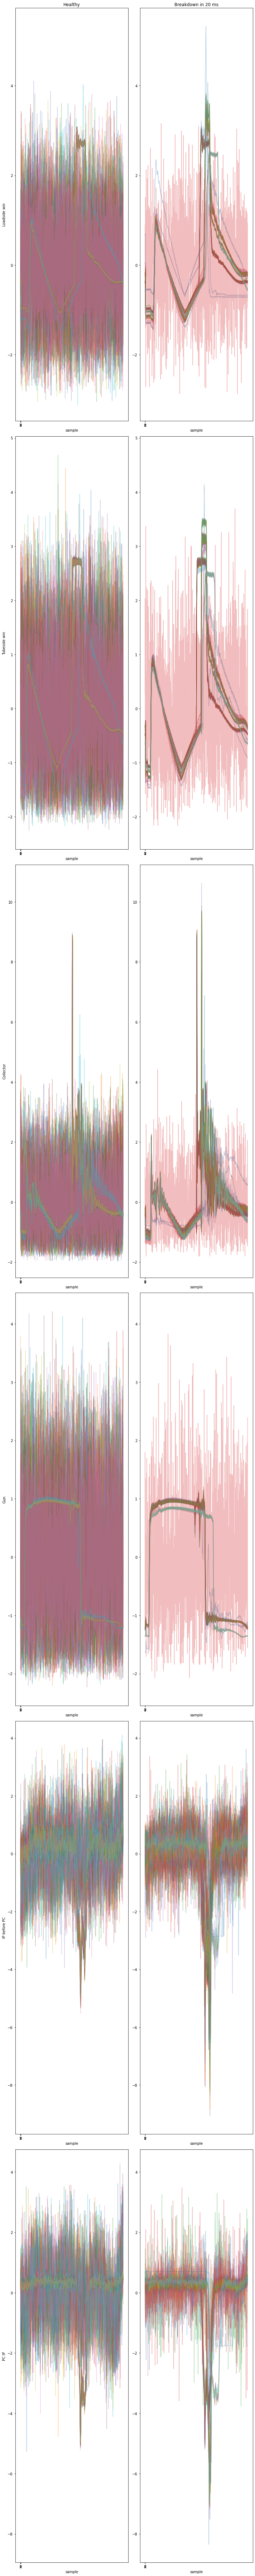

In [3]:
n_features = len(train.X[0, 0, :])
feature_list = ["Loadside win", "Tubeside win",
                "Collector", "Gun", "IP before PC",
                "PC IP", "WG IP", "IP Load",
                "IP before structure", "US Beam Axis IP",
                "Klystron Flange Temp", "Load Temp",
                "PC Left Cavity Temp", "PC Right Cavity Temp",
                "Bunker WG Temp", "Structure Input Temp",
                "Chiller 1", "Chiller 2", "Chiller 3",
                "PKI FT avg", "PSI FT avg", "PSR FT avg",
                "PSI max", "PSR max", "PEI max",
                "DC Down min", "DC Up min",
                "PSI Pulse Width"]
fig, ax = plt.subplots(n_features,2, figsize=(10,100))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.argmax(axis=1) == 0][:100,:,i].T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(feature_list[i])
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.argmax(axis=1) == 1][:100,:,i].T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

# Create Classifier Model
To create a classifier model an instance of the `Classifier` class is created.
To do this some hyperparameters are needed. These are loaded from a ´.json´ file.

In [4]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# define and fit classifier
clf = Classifier(input_shape=train.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

# Fit Model
After the model is created it has to be fitted to the data. This is done using the `fit_classifier` method.
Alternatively if a model already has been trained, the trained weights can be loaded.

In [5]:
clf.fit_classifier(train, valid)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
125/125 [==============================] - 12s 70ms/step - loss: 0.6967 - tp: 1024.0000 - fp: 969.0000 - tn: 1024.0000 - fn: 969.0000 - accuracy: 0.5138 - precision: 0.5138 - recall: 0.5138 - auc: 0.4034 - prc: 0.4227 - val_loss: 0.6660 - val_tp: 608.0000 - val_fp: 28.0000 - val_tn: 608.0000 - val_fn: 28.0000 - val_accuracy: 0.9560 - val_precision: 0.9560 - val_recall: 0.9560 - val_auc: 0.9593 - val_prc: 0.9532
Epoch 2/500
125/125 [==============================] - 19s 155ms/step - loss: 0.6934 - tp: 1831.0000 - fp: 162.0000 - tn: 1831.0000 - fn: 162.0000 - accuracy: 0.9187 - precision: 0.9187 - recall: 0.9187 - auc: 0.9240 - prc: 0.9064 - val_loss: 0.6926 - val_tp: 106.0000 - val_fp: 530.0000 - val_tn: 106.0000 - val_fn: 530.0000 - val_accuracy: 0.1667 - val_precision: 0.1667 - val_recall: 0.1667 - val_auc: 0.5970 - val_prc: 0.6257
Epoch

125/125 [==============================] - 22s 178ms/step - loss: 0.6999 - tp: 765.0000 - fp: 1228.0000 - tn: 765.0000 - fn: 1228.0000 - accuracy: 0.3838 - precision: 0.3838 - recall: 0.3838 - auc: 0.4292 - prc: 0.5237 - val_loss: 0.7351 - val_tp: 94.0000 - val_fp: 542.0000 - val_tn: 94.0000 - val_fn: 542.0000 - val_accuracy: 0.1478 - val_precision: 0.1478 - val_recall: 0.1478 - val_auc: 0.2064 - val_prc: 0.4161: 182.0000 - fn: 458.0000 - accuracy: 0.2844 - precision: 0.2 - ETA: 12s - loss: 0.6880 - tp: 427.0000 - fp: 597.0000 - tn: 427.0000 - fn: 597.0000 - accuracy: 0.4170 - precision: 0.4170 - recall: 0.4170 - ETA: 9s - loss: 0.6861 - tp: 668.0000 - fp: 612.0000 - tn: 668.0000 - fn: 612.0000 - accuracy: 0.5219 - precision: 0.5219 - recall: 0.5219 - - ETA: 3s - loss: 0.6939 - tp: 721.0000 - fp: 975.0000 - tn: 721.0000 - fn: 975.0000 - accuracy: 0.4251 - precision: 0.4251 - recall: 0.4251 - auc: 0
Epoch 12/500
125/125 [==============================] - 21s 170ms/step - loss: 0.6967 - 

125/125 [==============================] - 12s 99ms/step - loss: 0.6861 - tp: 446.0000 - fp: 1547.0000 - tn: 446.0000 - fn: 1547.0000 - accuracy: 0.2238 - precision: 0.2238 - recall: 0.2238 - auc: 0.2544 - prc: 0.4217 - val_loss: 0.6693 - val_tp: 105.0000 - val_fp: 531.0000 - val_tn: 105.0000 - val_fn: 531.0000 - val_accuracy: 0.1651 - val_precision: 0.1651 - val_recall: 0.1651 - val_auc: 0.2544 - val_prc: 0.4529
Epoch 26/500
125/125 [==============================] - 15s 118ms/step - loss: 0.6846 - tp: 559.0000 - fp: 1434.0000 - tn: 559.0000 - fn: 1434.0000 - accuracy: 0.2805 - precision: 0.2805 - recall: 0.2805 - auc: 0.2544 - prc: 0.4157 - val_loss: 0.6398 - val_tp: 282.0000 - val_fp: 354.0000 - val_tn: 282.0000 - val_fn: 354.0000 - val_accuracy: 0.4434 - val_precision: 0.4434 - val_recall: 0.4434 - val_auc: 0.4324 - val_prc: 0.5254
Epoch 27/500
125/125 [==============================] - 13s 106ms/step - loss: 0.6841 - tp: 444.0000 - fp: 1549.0000 - tn: 444.0000 - fn: 1549.0000 - ac

125/125 [==============================] - 16s 130ms/step - loss: 0.6713 - tp: 1202.0000 - fp: 791.0000 - tn: 1202.0000 - fn: 791.0000 - accuracy: 0.6031 - precision: 0.6031 - recall: 0.6031 - auc: 0.5907 - prc: 0.5774 - val_loss: 0.7012 - val_tp: 230.0000 - val_fp: 406.0000 - val_tn: 230.0000 - val_fn: 406.0000 - val_accuracy: 0.3616 - val_precision: 0.3616 - val_recall: 0.3616 - val_auc: 0.3282 - val_prc: 0.4630
Epoch 42/500
125/125 [==============================] - 13s 102ms/step - loss: 0.6754 - tp: 1089.0000 - fp: 904.0000 - tn: 1089.0000 - fn: 904.0000 - accuracy: 0.5464 - precision: 0.5464 - recall: 0.5464 - auc: 0.5295 - prc: 0.5358 - val_loss: 0.7022 - val_tp: 247.0000 - val_fp: 389.0000 - val_tn: 247.0000 - val_fn: 389.0000 - val_accuracy: 0.3884 - val_precision: 0.3884 - val_recall: 0.3884 - val_auc: 0.3296 - val_prc: 0.4590
Epoch 43/500
125/125 [==============================] - 13s 102ms/step - loss: 0.6773 - tp: 1146.0000 - fp: 847.0000 - tn: 1146.0000 - fn: 847.0000 - a

125/125 [==============================] - 12s 97ms/step - loss: 0.6498 - tp: 1357.0000 - fp: 636.0000 - tn: 1357.0000 - fn: 636.0000 - accuracy: 0.6809 - precision: 0.6809 - recall: 0.6809 - auc: 0.6741 - prc: 0.6441 - val_loss: 0.7053 - val_tp: 293.0000 - val_fp: 343.0000 - val_tn: 293.0000 - val_fn: 343.0000 - val_accuracy: 0.4607 - val_precision: 0.4607 - val_recall: 0.4607 - val_auc: 0.4656 - val_prc: 0.5023
Epoch 60/500
125/125 [==============================] - 12s 96ms/step - loss: 0.6550 - tp: 1335.0000 - fp: 658.0000 - tn: 1335.0000 - fn: 658.0000 - accuracy: 0.6698 - precision: 0.6698 - recall: 0.6698 - auc: 0.6926 - prc: 0.6598 - val_loss: 0.6254 - val_tp: 463.0000 - val_fp: 173.0000 - val_tn: 463.0000 - val_fn: 173.0000 - val_accuracy: 0.7280 - val_precision: 0.7280 - val_recall: 0.7280 - val_auc: 0.7844 - val_prc: 0.7674
Epoch 61/500
125/125 [==============================] - 12s 96ms/step - loss: 0.6415 - tp: 1555.0000 - fp: 438.0000 - tn: 1555.0000 - fn: 438.0000 - accu

125/125 [==============================] - 12s 99ms/step - loss: 0.6128 - tp: 1317.0000 - fp: 676.0000 - tn: 1317.0000 - fn: 676.0000 - accuracy: 0.6608 - precision: 0.6608 - recall: 0.6608 - auc: 0.7252 - prc: 0.7197 - val_loss: 0.6333 - val_tp: 339.0000 - val_fp: 297.0000 - val_tn: 339.0000 - val_fn: 297.0000 - val_accuracy: 0.5330 - val_precision: 0.5330 - val_recall: 0.5330 - val_auc: 0.5825 - val_prc: 0.610645.0000 - tn: 507.0000 - fn: 245.0000 - ac
Epoch 78/500
125/125 [==============================] - 12s 99ms/step - loss: 0.6060 - tp: 1344.0000 - fp: 649.0000 - tn: 1344.0000 - fn: 649.0000 - accuracy: 0.6744 - precision: 0.6744 - recall: 0.6744 - auc: 0.7513 - prc: 0.7456 - val_loss: 0.6762 - val_tp: 301.0000 - val_fp: 335.0000 - val_tn: 301.0000 - val_fn: 335.0000 - val_accuracy: 0.4733 - val_precision: 0.4733 - val_recall: 0.4733 - val_auc: 0.5199 - val_prc: 0.5679: 410.0000 - tn: 790.0000 - fn: 410.0000 - accuracy: 0.6583 - precision: 
Epoch 79/500
125/125 [================

Epoch 94/500
125/125 [==============================] - 12s 99ms/step - loss: 0.5726 - tp: 1422.0000 - fp: 571.0000 - tn: 1422.0000 - fn: 571.0000 - accuracy: 0.7135 - precision: 0.7135 - recall: 0.7135 - auc: 0.7957 - prc: 0.7942 - val_loss: 0.9854 - val_tp: 110.0000 - val_fp: 526.0000 - val_tn: 110.0000 - val_fn: 526.0000 - val_accuracy: 0.1730 - val_precision: 0.1730 - val_recall: 0.1730 - val_auc: 0.2359 - val_prc: 0.43607118 - recall: 0.7118 - auc
Epoch 95/500
125/125 [==============================] - 12s 99ms/step - loss: 0.5927 - tp: 1161.0000 - fp: 832.0000 - tn: 1161.0000 - fn: 832.0000 - accuracy: 0.5825 - precision: 0.5825 - recall: 0.5825 - auc: 0.6433 - prc: 0.6696 - val_loss: 0.7410 - val_tp: 204.0000 - val_fp: 432.0000 - val_tn: 204.0000 - val_fn: 432.0000 - val_accuracy: 0.3208 - val_precision: 0.3208 - val_recall: 0.3208 - val_auc: 0.3075 - val_prc: 0.4584
Epoch 96/500
125/125 [==============================] - 12s 99ms/step - loss: 0.5738 - tp: 1374.0000 - fp: 619.00

125/125 [==============================] - 22s 177ms/step - loss: 0.5471 - tp: 1376.0000 - fp: 617.0000 - tn: 1376.0000 - fn: 617.0000 - accuracy: 0.6904 - precision: 0.6904 - recall: 0.6904 - auc: 0.7813 - prc: 0.7889 - val_loss: 0.9029 - val_tp: 246.0000 - val_fp: 390.0000 - val_tn: 246.0000 - val_fn: 390.0000 - val_accuracy: 0.3868 - val_precision: 0.3868 - val_recall: 0.3868 - val_auc: 0.3799 - val_prc: 0.4910- tn: 429.0000 - fn - ETA: 3s - loss: 0.5591 - tp: 1118.0000 - fp: 546.0000 - tn: 1118.0000 - fn: 546.0000 - accuracy: 0.6719 - precision: 0.6719 - recall: 0.6719 - auc:
Epoch 110/500
125/125 [==============================] - 14s 114ms/step - loss: 0.5523 - tp: 1397.0000 - fp: 596.0000 - tn: 1397.0000 - fn: 596.0000 - accuracy: 0.7010 - precision: 0.7010 - recall: 0.7010 - auc: 0.7843 - prc: 0.7863 - val_loss: 0.6435 - val_tp: 380.0000 - val_fp: 256.0000 - val_tn: 380.0000 - val_fn: 256.0000 - val_accuracy: 0.5975 - val_precision: 0.5975 - val_recall: 0.5975 - val_auc: 0.6470

125/125 [==============================] - 19s 148ms/step - loss: 0.5113 - tp: 1433.0000 - fp: 560.0000 - tn: 1433.0000 - fn: 560.0000 - accuracy: 0.7190 - precision: 0.7190 - recall: 0.7190 - auc: 0.8075 - prc: 0.8122 - val_loss: 0.7394 - val_tp: 368.0000 - val_fp: 268.0000 - val_tn: 368.0000 - val_fn: 268.0000 - val_accuracy: 0.5786 - val_precision: 0.5786 - val_recall: 0.5786 - val_auc: 0.6101 - val_prc: 0.6339n: 428.0000 - accuracy: 0.7351 - precision: 0.7351 - recall: 0.7351 - auc - ETA: 0s - loss: 0.5146 - tp: 1414.0000 - fp: 554.0000 - tn: 1414.0000 - fn: 554.0000 - accuracy: 0.7185 - precision: 0.7185 - recall: 0.7185 - auc: 0.8066 - prc: 0.8
Epoch 126/500
125/125 [==============================] - 13s 100ms/step - loss: 0.4899 - tp: 1484.0000 - fp: 509.0000 - tn: 1484.0000 - fn: 509.0000 - accuracy: 0.7446 - precision: 0.7446 - recall: 0.7446 - auc: 0.8348 - prc: 0.8357 - val_loss: 0.9381 - val_tp: 305.0000 - val_fp: 331.0000 - val_tn: 305.0000 - val_fn: 331.0000 - val_accurac

125/125 [==============================] - 13s 104ms/step - loss: 0.4550 - tp: 1541.0000 - fp: 452.0000 - tn: 1541.0000 - fn: 452.0000 - accuracy: 0.7732 - precision: 0.7732 - recall: 0.7732 - auc: 0.8629 - prc: 0.8653 - val_loss: 0.4905 - val_tp: 492.0000 - val_fp: 144.0000 - val_tn: 492.0000 - val_fn: 144.0000 - val_accuracy: 0.7736 - val_precision: 0.7736 - val_recall: 0.7736 - val_auc: 0.8713 - val_prc: 0.8744.0000 - tn: 327.0000 - fn: 73.0000 - accuracy: 0.8175 - precision: 0.8175 - recall: 0.8175 - auc: 0. - ETA: 7s - loss: 0.4021 - tp: 563.0000 - fp: 125.0000 - tn: 563.0000 - fn: 125.0000 - accuracy: 0.8183 - precision: 0.8183 -  - ETA: 3s - loss: 0.4738 - tp: 1013.0000 - fp: 347.0000 - tn: 1013.0000 - fn: 347.0000 - accuracy: 0.7449 - precision: 0.7449 - recall: 0.7449 - auc: 0.8 - ETA: 2s - loss: 0.4727 - tp: 1235.0000 - fp: 397.0000 - tn: 1235.0000 - fn: 397.0000 - accuracy: 0.7567 - precision: 0.7567 - recall: 0.7567 - auc: 0.8459 - prc: 0.84 - ETA: 1s - loss: 0.4708 - tp: 1

Epoch 152/500
125/125 [==============================] - 12s 100ms/step - loss: 0.4005 - tp: 1616.0000 - fp: 377.0000 - tn: 1616.0000 - fn: 377.0000 - accuracy: 0.8108 - precision: 0.8108 - recall: 0.8108 - auc: 0.8945 - prc: 0.8959 - val_loss: 1.1015 - val_tp: 348.0000 - val_fp: 288.0000 - val_tn: 348.0000 - val_fn: 288.0000 - val_accuracy: 0.5472 - val_precision: 0.5472 - val_recall: 0.5472 - val_auc: 0.5854 - val_prc: 0.60250000 - accuracy: 0.8007 - precision: 0.8007 - recall: 0.8007 - auc: 0.8907 - prc: 0 - ETA: 1s - loss: 0.3884 - tp: 1364.0000 - fp: 332.0000 - tn: 1364.0000 - fn: 332.0000 - accuracy: 0.8042 - precision: 0.8042 - recall: 0.8042 - auc: 0.8 - ETA: 0s - loss: 0.3940 - tp: 1601.0000 - fp: 367.0000 - tn: 1601.0000 - fn: 367.0000 - accuracy: 0.8135 - precision: 0.8135 - recall: 0.8135 - auc: 0.8973 - prc: 0.8
Epoch 153/500
125/125 [==============================] - 12s 99ms/step - loss: 0.4011 - tp: 1530.0000 - fp: 463.0000 - tn: 1530.0000 - fn: 463.0000 - accuracy: 0.7

125/125 [==============================] - 13s 104ms/step - loss: 0.3868 - tp: 1585.0000 - fp: 408.0000 - tn: 1585.0000 - fn: 408.0000 - accuracy: 0.7953 - precision: 0.7953 - recall: 0.7953 - auc: 0.8962 - prc: 0.8998 - val_loss: 1.1618 - val_tp: 335.0000 - val_fp: 301.0000 - val_tn: 335.0000 - val_fn: 301.0000 - val_accuracy: 0.5267 - val_precision: 0.5267 - val_recall: 0.5267 - val_auc: 0.5569 - val_prc: 0.581029.0000 - tn: 479.0000 - fn: 129.0000 - accuracy: 0.7878 - precision: 0.7878 - recall: 0 - ETA: 5s - loss: 0.3916 - tp: 895.0000 - fp: 241.0000 - tn: 895.0000 - fn: 241.0000 - accuracy: 0.7879 - precisi
Epoch 166/500
125/125 [==============================] - 13s 104ms/step - loss: 0.3654 - tp: 1637.0000 - fp: 356.0000 - tn: 1637.0000 - fn: 356.0000 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.9094 - prc: 0.9104 - val_loss: 0.7922 - val_tp: 422.0000 - val_fp: 214.0000 - val_tn: 422.0000 - val_fn: 214.0000 - val_accuracy: 0.6635 - val_precision: 0.6635 - val

125/125 [==============================] - 13s 104ms/step - loss: 0.3861 - tp: 1658.0000 - fp: 335.0000 - tn: 1658.0000 - fn: 335.0000 - accuracy: 0.8319 - precision: 0.8319 - recall: 0.8319 - auc: 0.9141 - prc: 0.9140 - val_loss: 0.8820 - val_tp: 409.0000 - val_fp: 227.0000 - val_tn: 409.0000 - val_fn: 227.0000 - val_accuracy: 0.6431 - val_precision: 0.6431 - val_recall: 0.6431 - val_auc: 0.6877 - val_prc: 0.6847 tn: 1011.0000 - fn: 205.0000 - accuracy: 0.8314 - precision: 0.
Epoch 175/500
125/125 [==============================] - 13s 104ms/step - loss: 0.3731 - tp: 1632.0000 - fp: 361.0000 - tn: 1632.0000 - fn: 361.0000 - accuracy: 0.8189 - precision: 0.8189 - recall: 0.8189 - auc: 0.9062 - prc: 0.9074 - val_loss: 1.2659 - val_tp: 340.0000 - val_fp: 296.0000 - val_tn: 340.0000 - val_fn: 296.0000 - val_accuracy: 0.5346 - val_precision: 0.5346 - val_recall: 0.5346 - val_auc: 0.5362 - val_prc: 0.5526 392.0000 - fn: 104.0000 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - auc:

125/125 [==============================] - 13s 104ms/step - loss: 0.3130 - tp: 1690.0000 - fp: 303.0000 - tn: 1690.0000 - fn: 303.0000 - accuracy: 0.8480 - precision: 0.8480 - recall: 0.8480 - auc: 0.9344 - prc: 0.9356 - val_loss: 0.5456 - val_tp: 499.0000 - val_fp: 137.0000 - val_tn: 499.0000 - val_fn: 137.0000 - val_accuracy: 0.7846 - val_precision: 0.7846 - val_recall: 0.7846 - val_auc: 0.8811 - val_prc: 0.87760
Epoch 184/500
125/125 [==============================] - 13s 104ms/step - loss: 0.3133 - tp: 1690.0000 - fp: 303.0000 - tn: 1690.0000 - fn: 303.0000 - accuracy: 0.8480 - precision: 0.8480 - recall: 0.8480 - auc: 0.9326 - prc: 0.9342 - val_loss: 0.4931 - val_tp: 515.0000 - val_fp: 121.0000 - val_tn: 515.0000 - val_fn: 121.0000 - val_accuracy: 0.8097 - val_precision: 0.8097 - val_recall: 0.8097 - val_auc: 0.8919 - val_prc: 0.89120.0000 - fn: 118.0000 - accuracy: 0.8728 - precision: 0.8728 - recall: 0.8728 - auc: 0.9489 - - ETA: 5s - loss: 0.2826 - tp: 977.0000 - fp: 143.0000 -

125/125 [==============================] - 12s 98ms/step - loss: 0.2612 - tp: 1748.0000 - fp: 245.0000 - tn: 1748.0000 - fn: 245.0000 - accuracy: 0.8771 - precision: 0.8771 - recall: 0.8771 - auc: 0.9531 - prc: 0.9543 - val_loss: 0.6816 - val_tp: 492.0000 - val_fp: 144.0000 - val_tn: 492.0000 - val_fn: 144.0000 - val_accuracy: 0.7736 - val_precision: 0.7736 - val_recall: 0.7736 - val_auc: 0.8569 - val_prc: 0.8490
Epoch 201/500
125/125 [==============================] - 12s 99ms/step - loss: 0.2906 - tp: 1700.0000 - fp: 293.0000 - tn: 1700.0000 - fn: 293.0000 - accuracy: 0.8530 - precision: 0.8530 - recall: 0.8530 - auc: 0.9392 - prc: 0.9402 - val_loss: 0.6704 - val_tp: 505.0000 - val_fp: 131.0000 - val_tn: 505.0000 - val_fn: 131.0000 - val_accuracy: 0.7940 - val_precision: 0.7940 - val_recall: 0.7940 - val_auc: 0.8657 - val_prc: 0.8551
Epoch 202/500
125/125 [==============================] - 12s 99ms/step - loss: 0.2744 - tp: 1748.0000 - fp: 245.0000 - tn: 1748.0000 - fn: 245.0000 - ac

125/125 [==============================] - 8s 66ms/step - loss: 0.2389 - tp: 1775.0000 - fp: 218.0000 - tn: 1775.0000 - fn: 218.0000 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9613 - prc: 0.9627 - val_loss: 0.7538 - val_tp: 499.0000 - val_fp: 137.0000 - val_tn: 499.0000 - val_fn: 137.0000 - val_accuracy: 0.7846 - val_precision: 0.7846 - val_recall: 0.7846 - val_auc: 0.8709 - val_prc: 0.8608
Epoch 218/500
125/125 [==============================] - 14s 114ms/step - loss: 0.2540 - tp: 1763.0000 - fp: 230.0000 - tn: 1763.0000 - fn: 230.0000 - accuracy: 0.8846 - precision: 0.8846 - recall: 0.8846 - auc: 0.9552 - prc: 0.9547 - val_loss: 0.7880 - val_tp: 493.0000 - val_fp: 143.0000 - val_tn: 493.0000 - val_fn: 143.0000 - val_accuracy: 0.7752 - val_precision: 0.7752 - val_recall: 0.7752 - val_auc: 0.8549 - val_prc: 0.8430
Epoch 219/500
125/125 [==============================] - 23s 181ms/step - loss: 0.2338 - tp: 1765.0000 - fp: 228.0000 - tn: 1765.0000 - fn: 228.0000 - a

125/125 [==============================] - 21s 167ms/step - loss: 0.1810 - tp: 1820.0000 - fp: 173.0000 - tn: 1820.0000 - fn: 173.0000 - accuracy: 0.9132 - precision: 0.9132 - recall: 0.9132 - auc: 0.9748 - prc: 0.9749 - val_loss: 0.4740 - val_tp: 579.0000 - val_fp: 57.0000 - val_tn: 579.0000 - val_fn: 57.0000 - val_accuracy: 0.9104 - val_precision: 0.9104 - val_recall: 0.9104 - val_auc: 0.9639 - val_prc: 0.9579: 5.0000 - tn: 75.0000 - fn: 5.0000 - accuracy: 0.9375 - precision: 0.9375 -  - ETA: 19s - loss: 0.1543 - tp: 387.0000 - fp: 29.0000 - tn: 387.0000 - fn: 29.0000 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9826 - prc: 0.98 - ETA: 19s - loss: 0.1512 - tp: 403.0000 - fp: 29.0000 - tn: 403.0000 - fn: 29.0000 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9831 - prc: 0.98 - ETA: 19s - loss: 0.1711 - tp: 419.0000 - fp: 29.0000 - tn: 419.0000 - fn: 29.0000 - accuracy: 0.9353 - precis - ETA: 13s - loss: 0.1925 - tp: 823.0000 - fp: 73.0000 - tn: 82

125/125 [==============================] - 12s 96ms/step - loss: 0.1421 - tp: 1859.0000 - fp: 134.0000 - tn: 1859.0000 - fn: 134.0000 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9841 - prc: 0.9840 - val_loss: 0.7812 - val_tp: 507.0000 - val_fp: 129.0000 - val_tn: 507.0000 - val_fn: 129.0000 - val_accuracy: 0.7972 - val_precision: 0.7972 - val_recall: 0.7972 - val_auc: 0.8704 - val_prc: 0.8598: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.985
Epoch 250/500
125/125 [==============================] - 12s 99ms/step - loss: 0.1444 - tp: 1872.0000 - fp: 121.0000 - tn: 1872.0000 - fn: 121.0000 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9856 - prc: 0.9860 - val_loss: 0.8722 - val_tp: 508.0000 - val_fp: 128.0000 - val_tn: 508.0000 - val_fn: 128.0000 - val_accuracy: 0.7987 - val_precision: 0.7987 - val_recall: 0.7987 - val_auc: 0.8756 - val_prc: 0.8633- accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9782 -  - ETA: 6s - loss: 0.18

125/125 [==============================] - 12s 99ms/step - loss: 0.2318 - tp: 1790.0000 - fp: 203.0000 - tn: 1790.0000 - fn: 203.0000 - accuracy: 0.8981 - precision: 0.8981 - recall: 0.8981 - auc: 0.9626 - prc: 0.9593 - val_loss: 0.8735 - val_tp: 505.0000 - val_fp: 131.0000 - val_tn: 505.0000 - val_fn: 131.0000 - val_accuracy: 0.7940 - val_precision: 0.7940 - val_recall: 0.7940 - val_auc: 0.8672 - val_prc: 0.8553
Epoch 263/500
125/125 [==============================] - 12s 98ms/step - loss: 0.1559 - tp: 1853.0000 - fp: 140.0000 - tn: 1853.0000 - fn: 140.0000 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9815 - prc: 0.9818 - val_loss: 0.5730 - val_tp: 557.0000 - val_fp: 79.0000 - val_tn: 557.0000 - val_fn: 79.0000 - val_accuracy: 0.8758 - val_precision: 0.8758 - val_recall: 0.8758 - val_auc: 0.9393 - val_prc: 0.9292
Epoch 264/500
125/125 [==============================] - 12s 99ms/step - loss: 0.1237 - tp: 1883.0000 - fp: 110.0000 - tn: 1883.0000 - fn: 110.0000 - accu

125/125 [==============================] - 12s 99ms/step - loss: 0.0932 - tp: 1912.0000 - fp: 81.0000 - tn: 1912.0000 - fn: 81.0000 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9936 - prc: 0.9937 - val_loss: 0.6389 - val_tp: 561.0000 - val_fp: 75.0000 - val_tn: 561.0000 - val_fn: 75.0000 - val_accuracy: 0.8821 - val_precision: 0.8821 - val_recall: 0.8821 - val_auc: 0.9411 - val_prc: 0.9312
Epoch 280/500
125/125 [==============================] - 12s 99ms/step - loss: 0.0829 - tp: 1917.0000 - fp: 76.0000 - tn: 1917.0000 - fn: 76.0000 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9935 - prc: 0.9934 - val_loss: 0.6714 - val_tp: 578.0000 - val_fp: 58.0000 - val_tn: 578.0000 - val_fn: 58.0000 - val_accuracy: 0.9088 - val_precision: 0.9088 - val_recall: 0.9088 - val_auc: 0.9514 - val_prc: 0.9405cy: 0.9678 - precision: 0.9678 - recall: 0.9
Epoch 281/500
125/125 [==============================] - 12s 99ms/step - loss: 0.2826 - tp: 1788.0000 - fp: 205.0000

125/125 [==============================] - 12s 99ms/step - loss: 0.0676 - tp: 1937.0000 - fp: 56.0000 - tn: 1937.0000 - fn: 56.0000 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9965 - prc: 0.9964 - val_loss: 1.2527 - val_tp: 504.0000 - val_fp: 132.0000 - val_tn: 504.0000 - val_fn: 132.0000 - val_accuracy: 0.7925 - val_precision: 0.7925 - val_recall: 0.7925 - val_auc: 0.8399 - val_prc: 0.8145: 23.0000 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9968 - prc: 0 - ETA: 6s - loss: 0.0680 - tp: 839.0000 - fp: 25.0000 - tn: 839.0000 - fn: 25.0000 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.971 - ETA: 3s - loss: 0.0653 - tp: 1291.0000 - fp: 37.0000 - tn: 1291.0000 - fn: 37.0000 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.997 - ETA: 2s - loss: 0.0713 - tp: 1521.0000 - fp: 47.0000 - tn: 1521.0000 - fn: 47.0000 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700
Epoch 294/500
125/125 [==============================] - 12s 99m

Epoch 310/500
125/125 [==============================] - 12s 99ms/step - loss: 0.0889 - tp: 1926.0000 - fp: 67.0000 - tn: 1926.0000 - fn: 67.0000 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9939 - prc: 0.9938 - val_loss: 0.7297 - val_tp: 559.0000 - val_fp: 77.0000 - val_tn: 559.0000 - val_fn: 77.0000 - val_accuracy: 0.8789 - val_precision: 0.8789 - val_recall: 0.8789 - val_auc: 0.9349 - val_prc: 0.9235cision: 0.9646 - recall: 0.9646 - auc: 0.9938 - pr - ETA: 0s - loss: 0.0891 - tp: 1778.0000 - fp: 62.0000 - tn: 1778.0000 - fn: 62.0000 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9939 - p
Epoch 311/500
125/125 [==============================] - 12s 99ms/step - loss: 0.0563 - tp: 1946.0000 - fp: 47.0000 - tn: 1946.0000 - fn: 47.0000 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9976 - prc: 0.9977 - val_loss: 0.8244 - val_tp: 546.0000 - val_fp: 90.0000 - val_tn: 546.0000 - val_fn: 90.0000 - val_accuracy: 0.8585 - val_precision: 0

125/125 [==============================] - 7s 56ms/step - loss: 0.0371 - tp: 1964.0000 - fp: 29.0000 - tn: 1964.0000 - fn: 29.0000 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9990 - prc: 0.9990 - val_loss: 0.8443 - val_tp: 570.0000 - val_fp: 66.0000 - val_tn: 570.0000 - val_fn: 66.0000 - val_accuracy: 0.8962 - val_precision: 0.8962 - val_recall: 0.8962 - val_auc: 0.9381 - val_prc: 0.9236
Epoch 326/500
125/125 [==============================] - 8s 66ms/step - loss: 0.0374 - tp: 1966.0000 - fp: 27.0000 - tn: 1966.0000 - fn: 27.0000 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9989 - prc: 0.9989 - val_loss: 1.0012 - val_tp: 550.0000 - val_fp: 86.0000 - val_tn: 550.0000 - val_fn: 86.0000 - val_accuracy: 0.8648 - val_precision: 0.8648 - val_recall: 0.8648 - val_auc: 0.9205 - val_prc: 0.9047
Epoch 327/500
125/125 [==============================] - 12s 97ms/step - loss: 0.0390 - tp: 1966.0000 - fp: 27.0000 - tn: 1966.0000 - fn: 27.0000 - accuracy: 0.98

125/125 [==============================] - 50s 399ms/step - loss: 0.0212 - tp: 1983.0000 - fp: 10.0000 - tn: 1983.0000 - fn: 10.0000 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - prc: 0.9998 - val_loss: 1.2187 - val_tp: 528.0000 - val_fp: 108.0000 - val_tn: 528.0000 - val_fn: 108.0000 - val_accuracy: 0.8302 - val_precision: 0.8302 - val_recall: 0.8302 - val_auc: 0.8901 - val_prc: 0.8689
Epoch 344/500
125/125 [==============================] - 38s 307ms/step - loss: 0.0278 - tp: 1973.0000 - fp: 20.0000 - tn: 1973.0000 - fn: 20.0000 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - prc: 0.9993 - val_loss: 1.0074 - val_tp: 557.0000 - val_fp: 79.0000 - val_tn: 557.0000 - val_fn: 79.0000 - val_accuracy: 0.8758 - val_precision: 0.8758 - val_recall: 0.8758 - val_auc: 0.9225 - val_prc: 0.9053
Epoch 345/500
125/125 [==============================] - 28s 220ms/step - loss: 0.0385 - tp: 1968.0000 - fp: 25.0000 - tn: 1968.0000 - fn: 25.0000 - accurac

125/125 [==============================] - 13s 106ms/step - loss: 0.0263 - tp: 1976.0000 - fp: 17.0000 - tn: 1976.0000 - fn: 17.0000 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - prc: 0.9996 - val_loss: 0.9891 - val_tp: 560.0000 - val_fp: 76.0000 - val_tn: 560.0000 - val_fn: 76.0000 - val_accuracy: 0.8805 - val_precision: 0.8805 - val_recall: 0.8805 - val_auc: 0.9241 - val_prc: 0.9081
Epoch 356/500
125/125 [==============================] - 12s 94ms/step - loss: 0.0296 - tp: 1972.0000 - fp: 21.0000 - tn: 1972.0000 - fn: 21.0000 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9995 - prc: 0.9995 - val_loss: 1.0123 - val_tp: 535.0000 - val_fp: 101.0000 - val_tn: 535.0000 - val_fn: 101.0000 - val_accuracy: 0.8412 - val_precision: 0.8412 - val_recall: 0.8412 - val_auc: 0.9095 - val_prc: 0.8932
Epoch 357/500
125/125 [==============================] - 12s 94ms/step - loss: 0.0429 - tp: 1954.0000 - fp: 39.0000 - tn: 1954.0000 - fn: 39.0000 - accuracy:

125/125 [==============================] - 12s 96ms/step - loss: 0.2241 - tp: 1815.0000 - fp: 178.0000 - tn: 1815.0000 - fn: 178.0000 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - auc: 0.9688 - prc: 0.9652 - val_loss: 2.3143 - val_tp: 428.0000 - val_fp: 208.0000 - val_tn: 428.0000 - val_fn: 208.0000 - val_accuracy: 0.6730 - val_precision: 0.6730 - val_recall: 0.6730 - val_auc: 0.7023 - val_prc: 0.6727
Epoch 375/500
125/125 [==============================] - 12s 96ms/step - loss: 0.6719 - tp: 1667.0000 - fp: 326.0000 - tn: 1667.0000 - fn: 326.0000 - accuracy: 0.8364 - precision: 0.8364 - recall: 0.8364 - auc: 0.9086 - prc: 0.8976 - val_loss: 3.1110 - val_tp: 344.0000 - val_fp: 292.0000 - val_tn: 344.0000 - val_fn: 292.0000 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 0.5409 - val_auc: 0.5347 - val_prc: 0.5255
Epoch 376/500
125/125 [==============================] - 12s 94ms/step - loss: 0.3561 - tp: 1742.0000 - fp: 251.0000 - tn: 1742.0000 - fn: 251.0000 - ac

125/125 [==============================] - 12s 95ms/step - loss: 0.0193 - tp: 1981.0000 - fp: 12.0000 - tn: 1981.0000 - fn: 12.0000 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - prc: 0.9997 - val_loss: 1.0851 - val_tp: 559.0000 - val_fp: 77.0000 - val_tn: 559.0000 - val_fn: 77.0000 - val_accuracy: 0.8789 - val_precision: 0.8789 - val_recall: 0.8789 - val_auc: 0.9210 - val_prc: 0.9036
Epoch 394/500
125/125 [==============================] - 12s 94ms/step - loss: 0.3814 - tp: 1792.0000 - fp: 201.0000 - tn: 1792.0000 - fn: 201.0000 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9574 - prc: 0.9520 - val_loss: 2.5552 - val_tp: 390.0000 - val_fp: 246.0000 - val_tn: 390.0000 - val_fn: 246.0000 - val_accuracy: 0.6132 - val_precision: 0.6132 - val_recall: 0.6132 - val_auc: 0.6417 - val_prc: 0.6142
Epoch 395/500
125/125 [==============================] - 12s 94ms/step - loss: 0.3430 - tp: 1699.0000 - fp: 294.0000 - tn: 1699.0000 - fn: 294.0000 - accura

125/125 [==============================] - 12s 96ms/step - loss: 0.0120 - tp: 1987.0000 - fp: 6.0000 - tn: 1987.0000 - fn: 6.0000 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0643 - val_tp: 537.0000 - val_fp: 99.0000 - val_tn: 537.0000 - val_fn: 99.0000 - val_accuracy: 0.8443 - val_precision: 0.8443 - val_recall: 0.8443 - val_auc: 0.9048 - val_prc: 0.8867
Epoch 413/500
125/125 [==============================] - 14s 109ms/step - loss: 0.0127 - tp: 1987.0000 - fp: 6.0000 - tn: 1987.0000 - fn: 6.0000 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9648 - val_tp: 555.0000 - val_fp: 81.0000 - val_tn: 555.0000 - val_fn: 81.0000 - val_accuracy: 0.8726 - val_precision: 0.8726 - val_recall: 0.8726 - val_auc: 0.9248 - val_prc: 0.9083
Epoch 414/500
125/125 [==============================] - 13s 104ms/step - loss: 0.0121 - tp: 1989.0000 - fp: 4.0000 - tn: 1989.0000 - fn: 4.0000 - accuracy: 0.9980

Epoch 431/500
125/125 [==============================] - 12s 93ms/step - loss: 0.0141 - tp: 1986.0000 - fp: 7.0000 - tn: 1986.0000 - fn: 7.0000 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0690 - val_tp: 540.0000 - val_fp: 96.0000 - val_tn: 540.0000 - val_fn: 96.0000 - val_accuracy: 0.8491 - val_precision: 0.8491 - val_recall: 0.8491 - val_auc: 0.9011 - val_prc: 0.8818
Epoch 432/500
125/125 [==============================] - 12s 93ms/step - loss: 0.0122 - tp: 1989.0000 - fp: 4.0000 - tn: 1989.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.9879 - val_tp: 553.0000 - val_fp: 83.0000 - val_tn: 553.0000 - val_fn: 83.0000 - val_accuracy: 0.8695 - val_precision: 0.8695 - val_recall: 0.8695 - val_auc: 0.9150 - val_prc: 0.8961
Epoch 433/500
125/125 [==============================] - 12s 97ms/step - loss: 0.0101 - tp: 1991.0000 - fp: 2.0000 - tn: 1991.0000 - fn: 2.0000 - accu

125/125 [==============================] - 12s 97ms/step - loss: 0.0083 - tp: 1990.0000 - fp: 3.0000 - tn: 1990.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0067 - val_tp: 572.0000 - val_fp: 64.0000 - val_tn: 572.0000 - val_fn: 64.0000 - val_accuracy: 0.8994 - val_precision: 0.8994 - val_recall: 0.8994 - val_auc: 0.9290 - val_prc: 0.9118
Epoch 451/500
125/125 [==============================] - 12s 92ms/step - loss: 0.0074 - tp: 1990.0000 - fp: 3.0000 - tn: 1990.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.0397 - val_tp: 571.0000 - val_fp: 65.0000 - val_tn: 571.0000 - val_fn: 65.0000 - val_accuracy: 0.8978 - val_precision: 0.8978 - val_recall: 0.8978 - val_auc: 0.9252 - val_prc: 0.9071
Epoch 452/500
125/125 [==============================] - 12s 100ms/step - loss: 0.0065 - tp: 1991.0000 - fp: 2.0000 - tn: 1991.0000 - fn: 2.0000 - accuracy: 0.9990 

125/125 [==============================] - 13s 101ms/step - loss: 0.0058 - tp: 1992.0000 - fp: 1.0000 - tn: 1992.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2569 - val_tp: 555.0000 - val_fp: 81.0000 - val_tn: 555.0000 - val_fn: 81.0000 - val_accuracy: 0.8726 - val_precision: 0.8726 - val_recall: 0.8726 - val_auc: 0.9205 - val_prc: 0.9029
Epoch 470/500
125/125 [==============================] - 13s 102ms/step - loss: 0.0044 - tp: 1993.0000 - fp: 0.0000e+00 - tn: 1993.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.3090 - val_tp: 550.0000 - val_fp: 86.0000 - val_tn: 550.0000 - val_fn: 86.0000 - val_accuracy: 0.8648 - val_precision: 0.8648 - val_recall: 0.8648 - val_auc: 0.9196 - val_prc: 0.9017
Epoch 471/500
125/125 [==============================] - 13s 102ms/step - loss: 0.0040 - tp: 1993.0000 - fp: 0.0000e+00 - tn: 1993.0000 - fn: 0.0000e+00 -

Epoch 488/500
125/125 [==============================] - 12s 99ms/step - loss: 0.0054 - tp: 1993.0000 - fp: 0.0000e+00 - tn: 1993.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2417 - val_tp: 569.0000 - val_fp: 67.0000 - val_tn: 569.0000 - val_fn: 67.0000 - val_accuracy: 0.8947 - val_precision: 0.8947 - val_recall: 0.8947 - val_auc: 0.9315 - val_prc: 0.9157
Epoch 489/500
125/125 [==============================] - 12s 98ms/step - loss: 0.0045 - tp: 1993.0000 - fp: 0.0000e+00 - tn: 1993.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 1.2692 - val_tp: 570.0000 - val_fp: 66.0000 - val_tn: 570.0000 - val_fn: 66.0000 - val_accuracy: 0.8962 - val_precision: 0.8962 - val_recall: 0.8962 - val_auc: 0.9331 - val_prc: 0.9173
Epoch 490/500
125/125 [==============================] - 13s 106ms/step - loss: 0.0040 - tp: 1993.0000 - fp: 0.0000e+00 - tn: 1993.000

# Make Prediction
When the model has been fitted to the data, it can be used to make predictions.
Here the prediction is done on the kept out test set using the `predict` set.
To evaluate the performance of the model, the `evaluate` method can be used.

In [6]:
y_pred = clf.model.predict(x=test.X)

In [7]:
# eval classifier
results = clf.model.evaluate(x=test.X, y=test.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T


20/20 [==============================] - 1s 46ms/step - loss: 2.8215 - tp: 491.0000 - fp: 146.0000 - tn: 491.0000 - fn: 146.0000 - accuracy: 0.7708 - precision: 0.7708 - recall: 0.7708 - auc: 0.8126 - prc: 0.7812


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,2.821502,491.0,146.0,491.0,146.0,0.770801,0.770801,0.770801,0.812578,0.78124
